# Домашнее задание
## реализация алгоритма Q-learning
В данном задании реализовано обучение алгоритма Q-learning в среде `Taxi-v3`

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

# --- корректировка импортов в зависимых пакетах (подмена gym на gymnasium)
import sys
import gymnasium
sys.modules["gym"] = gymnasium
#----------------
import gymnasium as gym
from gym.wrappers import RecordVideo

from IPython.display import HTML
from base64 import b64encode

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
os.makedirs("./video", exist_ok=True)

def render_mp4(videopath: str) -> str:

    """
    Функция для рендеринга видео в формате mp4.
    Args:
    videopath - Путь к файлу с видео.
    """
    
    mp4 = open(videopath, 'rb').read()
    base64_encoded_mp4 = b64encode(mp4).decode()
    return f'<video width=600 controls><source src="data:video/mp4; base64,{base64_encoded_mp4}" type="video/mp4"></video>'

# инициализация среды "Taxi-v3"
env = gym.make("Taxi-v3", render_mode="rgb_array")
env = RecordVideo(env, video_folder="video", name_prefix=f"Taxi")

## Функции обучения агента

In [4]:
def q_learn(env, episodes, noisy_episodes, max_iterations, gamma=0.9, alpha=0.5):
    """
    Функция для обучения агента с использованием алгоритма Q-обучения.

    Args:
        env: Среда в которой агент учится
        episodes (int): Количество эпизодов
        noisy_episodes (int): Количество эпизодов с шумом
        max_iterations (int): Максимальное количество итераций в 1 эпизоде
        gammafloat): Коэффициент дисконтирования
        alpha (float): Скорость обучения
    """

    total_reward = {'sum_reward': [], 'avg_reward': []}
    all_rewards = []
    env_states = env.observation_space.n
    env_actions = env.action_space.n    

    Q = np.zeros((env_states, env_actions))
    epsilon = 1
    counter = 1
    
    for i in tqdm(range(episodes)):

        last100_episodes = []

        cumulative_reward = 0
        state, _ = env.reset()

        for j in range(max_iterations):
            
            # политика выбора действия (вероятность каждого выбора = epsilon / env_actions)
            policy = np.ones(env_actions) * epsilon / env_actions

            # ищем действие с максимальным значением q-функции
            max_action = np.argmax(Q[state])

            # уменьшается вероятность случайного выбора действия
            policy[max_action] += 1 - epsilon

            # выбор действия
            act = np.random.choice(np.arange(env_actions), p=policy)

            # выполняется ход агента и получение следующего состояния
            next_state, reward, done, _, _ = env.step(act)

            # обновление значения q-функции для текущего состояния и действия
            Q[state][act] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][act])

            cumulative_reward += reward
            last100_episodes.append(cumulative_reward)

            if done:
                break

            state = next_state

        all_rewards.append(cumulative_reward)

        epsilon = max(0, epsilon - 1 / noisy_episodes)
        counter += 1


        if counter % 100 == 0:
            total_reward['sum_reward'].append(np.sum(last100_episodes))
            total_reward['avg_reward'].append(np.mean(last100_episodes))
        total_reward['all_rewards'] = all_rewards

    return total_reward, Q

## Обучение агента

In [5]:
model = q_learn(env, episodes=800, noisy_episodes=700, max_iterations=500, gamma=0.995)
total_rewards = model[0] # награды
agent = model[1] #  Q-функция

100%|██████████| 800/800 [00:11<00:00, 72.25it/s] 


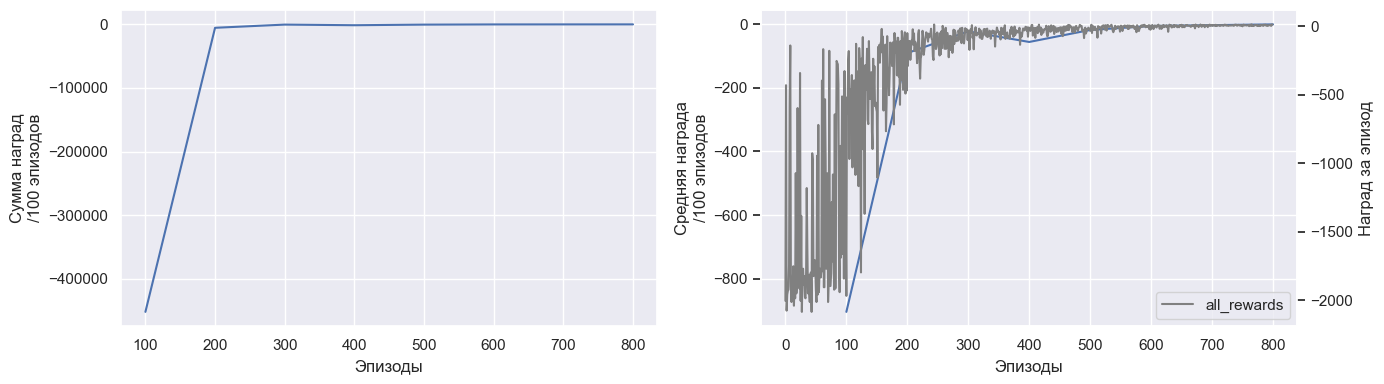

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(y=total_rewards['sum_reward'], x=list(range(100, (len(total_rewards['sum_reward'])+1)*100, 100)), ax=ax[0])
sns.lineplot(y=total_rewards['avg_reward'], x=list(range(100, (len(total_rewards['avg_reward'])+1)*100, 100)), ax=ax[1])

ax_2 = ax[1].twinx()
sns.lineplot(y=total_rewards['all_rewards'], x=list(range(len(total_rewards['all_rewards']))),
             ax=ax_2, label="all_rewards", color='grey')

ax[0].set_xlabel("Эпизоды")
ax[1].set_xlabel("Эпизоды")
ax[0].set_ylabel("Сумма наград\n/100 эпизодов")
ax[1].set_ylabel("Средняя награда\n/100 эпизодов")
ax_2.set_ylabel("Наград за эпизод")
ax_2.grid(False)

plt.tight_layout()
# plt.suptitle('Динамика обучения')
plt.show()
plt.close()

In [7]:
HTML(
    render_mp4(f"video/Taxi-episode-{max([int(i.split('.')[0].split('-')[-1]) for i in os.listdir('video')])}.mp4")
    )

## Тестирование агента

In [8]:
def run_trained_agent(env, Q, episodes=1, t_max=500, video_path="video"):
    """
    Функция для запуска (проверки) обученного агента в среде

    Args:
        env: Среда, в которой запускается агент
        Q (np.array): обученная Q-функция
        episodes (int): Количество эпизодов (1)
        t_max (int): Максимальное количество итераций в эпизоде      
        video_path (str): Путь для сохранения видео.
    """
       
    env = RecordVideo(env, video_folder=video_path, episode_trigger=lambda e: True)

    for episode in range(episodes):
        test_steps = 0
        state, _ = env.reset()
        # done = False
        

        for t in range(t_max):
            # Вмаксимальное действие по Q
            action = np.argmax(Q[state])
            next_state, reward, done, _, _ = env.step(action)

            state = next_state
            test_steps += 1
            if done:
                break
        
        print(f"Действие завершено в {test_steps} шагов")

    env.close()

In [9]:
run_trained_agent(env, agent)

HTML(
    render_mp4(f"video/rl-video-episode-0.mp4")
    )

Действие завершено в 12 шагов


Проверка показала, что обученный агент выбирает оптимальную траекторию.